# Fruit Classification: Black Berry or Golden Berry

First iteration of exploration and model training.

## Imports

In [6]:
import matplotlib.pyplot as plt
from pandas.core.common import flatten
import copy
import numpy as np
import random
import os
import glob
from pathlib import Path

import torch
import torch.nn as nn 
from torch import optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

from PIL import Image
from pillow_heif import register_heif_opener
import cv2

%matplotlib inline

## Converting images to correct format

In [7]:
def heic2jpg(heic_dir, jpg_dir):
    register_heif_opener()
    heic_files = [image for image in os.listdir(heic_dir) if '.heic' in image]
    
    for image in heic_files:
        tmp_img = Image.open(os.path.join(heic_dir, image))
        jpg_image = image.replace('.heic', '.jpg')
        if not os.path.exists(jpg_dir):
            os.makedirs(jpg_dir, exist_ok=True)
        tmp_img.save(os.path.join(jpg_dir, jpg_image))

In [8]:
# heic2jpg('fruits/mora', 'fruits/mora_jpg')

In [9]:
# heic2jpg('fruits/uchua', 'fruits/uchua_jpg')

## Resizing images

In [10]:
def resize_images(image_dir, dim):

    image_dir_paths = [image for image in os.listdir(image_dir) if image.endswith('.jpg')]
    for image_path in image_dir_paths:
        # opening image
        image = cv2.imread(os.path.join(image_dir, image_path))
        # resizing image
        resized_image = cv2.resize(image, [dim, dim])
        # plt.imshow(resized_image)
        # plt.show()
        # saving image
        cv2.imwrite(os.path.join(image_dir, image_path), resized_image)



In [11]:
# mora
# resize_images('fruits/mora_jpg/', 512)
# # uchua
# resize_images('fruits/uchua_jpg/', 512)


## Model definition

PyTorch requires us to define a Class or to use the model hub. We can do both:

In [12]:
class PretrainedResNet(nn.Module):
    def __init__(self, num_classes):
        super(PretrainedResNet, self).__init__()
        self.resnet = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
    
    def forward(self, x):
        return self.resnet(x)

## Dataset definition

### Define Transforms

In [13]:
train_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=360, p=0.5),
        A.RandomCrop(height=512, width=512),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.MultiplicativeNoise(multiplier=[0.5,2], per_channel=True, p=0.2),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
        ToTensorV2(),
    ]
)

test_transforms = A.Compose(
    [
        A.SmallestMaxSize(max_size=512),
        A.CenterCrop(height=512, width=512),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [14]:
train_data_path = os.path.join('data', 'train')
test_data_path = os.path.join('data','test')

train_image_paths = [] #to store image paths in list
classes = [] #to store class values

#1.
# get all the paths from train_data_path and append image paths and class to to respective lists
# eg. train path-> 'images/train/26.Pont_du_Gard/4321ee6695c23c7b.jpg'
# eg. class -> 26.Pont_du_Gard
for data_path in glob.glob(train_data_path + '/*'):
    classes.append(data_path.split('/')[-1]) 
    train_image_paths.append(glob.glob(data_path + '/*'))
    
train_image_paths = list(flatten(train_image_paths))
random.shuffle(train_image_paths)

print('train_image_path example: ', train_image_paths[0])
print('class example: ', classes[0])

#2.
# split train valid from train paths (80,20)
train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):] 

#3.
# create the test_image_paths
test_image_paths = []
for data_path in glob.glob(test_data_path + '/*'):
    test_image_paths.append(glob.glob(data_path + '/*'))

test_image_paths = list(flatten(test_image_paths))

print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))


train_image_path example:  data/train/mora/IMG_2127.jpg
class example:  uchua
Train size: 127
Valid size: 32
Test size: 69


In [15]:
def load_image_paths(train_data_path, test_data_path):
    train_image_paths = [] # to store image paths in a list
    classes = [] # to store class values

    # 1. Get all the paths from train_data_path and append image paths and class to respective lists
    for data_path in glob.glob(train_data_path + '/*'):
        classes.append(data_path.split('/')[-1]) 
        train_image_paths.append(glob.glob(data_path + '/*'))

    train_image_paths = list(flatten(train_image_paths))
    random.shuffle(train_image_paths)

    print('train_image_path example:', train_image_paths)
    print('class example:', classes)

    # 2. Split train valid from train paths (80,20)
    train_image_paths, valid_image_paths = train_image_paths[:int(0.8*len(train_image_paths))], train_image_paths[int(0.8*len(train_image_paths)):]

    # 3. Create the test_image_paths
    test_image_paths = []
    for data_path in glob.glob(test_data_path + '/*'):
        test_image_paths.append(glob.glob(data_path + '/*'))

    test_image_paths = list(flatten(test_image_paths))

    print("Train size: {}\nValid size: {}\nTest size: {}".format(len(train_image_paths), len(valid_image_paths), len(test_image_paths)))

    return train_image_paths, valid_image_paths, test_image_paths, classes


# Usage:
train_data_path = os.path.join('data', 'train')
test_data_path = os.path.join('data', 'test')

train_image_paths, valid_image_paths, test_image_paths, classes = load_image_paths(train_data_path, test_data_path)


train_image_path example: ['data/train/uchua/IMG_2007.jpg', 'data/train/uchua/IMG_2389.jpg', 'data/train/uchua/IMG_2008.jpg', 'data/train/uchua/IMG_1982.jpg', 'data/train/mora/IMG_2062.jpg', 'data/train/uchua/IMG_2299.jpg', 'data/train/uchua/IMG_1999.jpg', 'data/train/mora/IMG_2068.jpg', 'data/train/mora/IMG_2432.jpg', 'data/train/mora/IMG_2140.jpg', 'data/train/mora/IMG_2371.jpg', 'data/train/mora/IMG_2420.jpg', 'data/train/mora/IMG_2083.jpg', 'data/train/mora/IMG_2075.jpg', 'data/train/uchua/IMG_2002.jpg', 'data/train/mora/IMG_2080.jpg', 'data/train/uchua/IMG_1989.jpg', 'data/train/uchua/IMG_2110.jpg', 'data/train/uchua/IMG_2292.jpg', 'data/train/mora/IMG_2373.jpg', 'data/train/mora/IMG_2381.jpg', 'data/train/mora/IMG_2424.jpg', 'data/train/mora/IMG_2078.jpg', 'data/train/mora/IMG_2364.jpg', 'data/train/uchua/IMG_1985.jpg', 'data/train/uchua/IMG_2453.jpg', 'data/train/mora/IMG_2059.jpg', 'data/train/uchua/IMG_2456.jpg', 'data/train/mora/IMG_2086.jpg', 'data/train/uchua/IMG_2117.jpg',

In [16]:
idx_to_class = {i:j for i, j in enumerate(classes)}
class_to_idx = {value:key for key, value in idx_to_class.items()}

In [17]:
class_to_idx

{'uchua': 0, 'mora': 1}

In [18]:
class_to_idx

{'uchua': 0, 'mora': 1}

In [25]:
class FruitDataset(Dataset):

    def __init__(self, image_paths, transforms=False):
        self.image_paths = image_paths
        self.idx_to_class = {i:j for i, j in enumerate(['uchua', 'mora'])}
        self.class_to_idx = {value:key for key, value in self.idx_to_class.items()}
        self.transform = transforms
        
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_filepath = self.image_paths[idx]
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label = image_filepath.split('/')[-2]
        label = self.class_to_idx[label]

        if self.transform is not None:
            image = self.transform(image=image)["image"]

        return image, label
    
train_dataset = FruitDataset(train_image_paths, train_transforms)
valid_dataset = FruitDataset(valid_image_paths, test_transforms)
test_dataset = FruitDataset(test_image_paths, test_transforms)
    

In [26]:
print('The shape of tensor for 50th image in train dataset: ',train_dataset[49][0].shape)
print('The label for 50th image in train dataset: ',train_dataset[49][1])

The shape of tensor for 50th image in train dataset:  torch.Size([3, 512, 512])
The label for 50th image in train dataset:  0


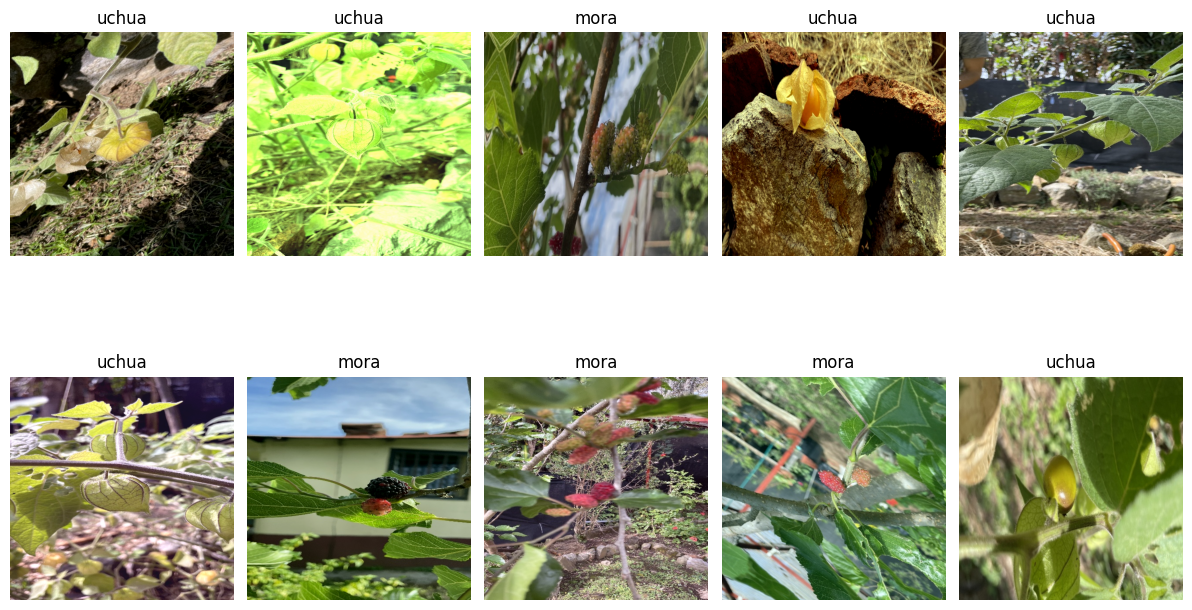

In [27]:
def visualize_augmentations(dataset, idx=0, samples=10, cols=5, random_img = False):
    
    dataset = copy.deepcopy(dataset)
    #we remove the normalize and tensor conversion from our augmentation pipeline
    dataset.transform = A.Compose([t for t in dataset.transform if not isinstance(t, (A.Normalize, ToTensorV2))])
    rows = samples // cols
    
        
    figure, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(12, 8))
    for i in range(samples):
        if random_img:
            idx = np.random.randint(1,len(dataset))
        image, lab = dataset[idx]
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_axis_off()
        ax.ravel()[i].set_title(idx_to_class[lab])
    plt.tight_layout(pad=1)
    plt.show()    

visualize_augmentations(train_dataset,np.random.randint(1,len(train_image_paths)), random_img = True)

## DataLoaders

In [28]:
train_loader = DataLoader(
    train_dataset, batch_size=16, shuffle=True
)
# since we do not train on valid and test datasets we can set shuffle to False, however, our dataset is ordered so for visualization and inference purposes will set shuffle to True
valid_loader = DataLoader(
    valid_dataset, batch_size=16, shuffle=True
)


test_loader = DataLoader(
    test_dataset, batch_size=16, shuffle=True
)

## Training Loop

In [23]:
from tqdm import tqdm

def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    best_accuracy = 0.0
    best_model_weights = None
    
    for epoch in tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
        
            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct_predictions / total_predictions
        
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f} - Accuracy: {epoch_accuracy:.4f}")

        val_running_loss = 0.0
        val_correct_predictions = 0
        val_total_predictions = 0

        model.eval()
        
        with torch.no_grad():
            for val_images, val_labels in valid_loader:
                val_images = val_images.to(device)
                val_labels = val_labels.to(device)
                
                val_outputs = model(val_images)
                val_loss = criterion(val_outputs, val_labels)
                
                val_running_loss += val_loss.item() * val_images.size(0)
                _, val_predicted = torch.max(val_outputs.data, 1)
                val_total_predictions += val_labels.size(0)
                val_correct_predictions += (val_predicted == val_labels).sum().item()
        
                val_epoch_loss = val_running_loss / len(valid_loader.dataset)
                val_epoch_accuracy = val_correct_predictions / val_total_predictions

        print(f"Validation Loss: {val_epoch_loss:.4f} - Validation Accuracy: {val_epoch_accuracy:.4f}")
        if val_epoch_accuracy > best_accuracy:
            best_accuracy = val_epoch_accuracy
            best_model_weights = copy.deepcopy(model.state_dict())
        
        
        scheduler.step()
    
    print("Training complete!")
    print(f"Best Validation Accuracy: {best_accuracy:.4f}")
    
    model.load_state_dict(best_model_weights)
    return model

In [29]:
# Device
device = torch.device("mps" if torch.has_mps else "cpu")

# Initializing the model
num_classes = len(classes)
model = PretrainedResNet(num_classes)
model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Epochs
num_epochs = 3

trained_model = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, num_epochs)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1/3 - Loss: 0.4403 - Accuracy: 0.7323


 33%|███▎      | 1/3 [01:14<02:28, 74.23s/it]

Validation Loss: 0.2693 - Validation Accuracy: 0.9375
Epoch 2/3 - Loss: 0.1005 - Accuracy: 0.9606


 67%|██████▋   | 2/3 [02:28<01:14, 74.39s/it]

Validation Loss: 0.1080 - Validation Accuracy: 0.9688
Epoch 3/3 - Loss: 0.1095 - Accuracy: 0.9685


100%|██████████| 3/3 [03:42<00:00, 74.26s/it]

Validation Loss: 0.0379 - Validation Accuracy: 0.9688
Training complete!
Best Validation Accuracy: 0.9688


## Test model on TestLoader

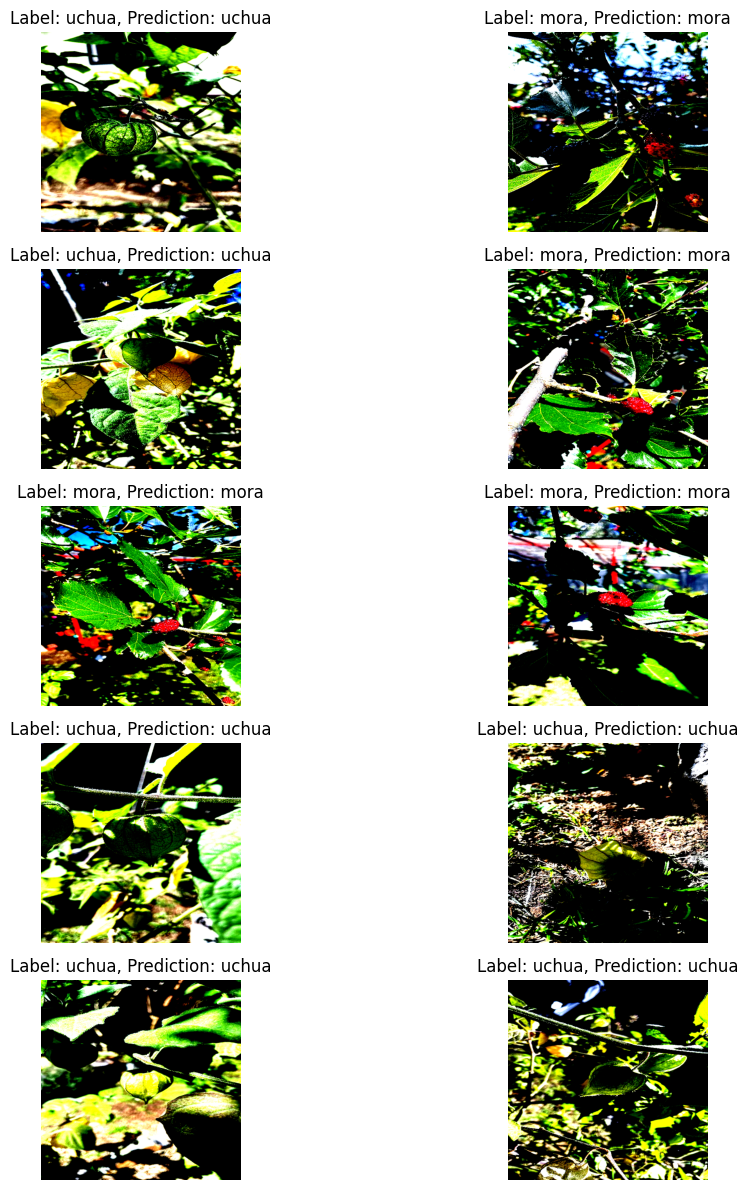

In [30]:
import matplotlib.pyplot as plt

def plot_results(model, test_loader, num_images=5, grid_cols=5):
    # device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    device = torch.device("mps" if torch.has_mps else "cpu")
    model.to(device)
    
    model.eval()
    
    images_per_row = grid_cols
    grid_rows = (num_images + images_per_row - 1) // images_per_row
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            fig, axes = plt.subplots(grid_rows, images_per_row, figsize=(12, 12))
            fig.subplots_adjust(hspace=0.1)
            
            for j, ax in enumerate(axes.flat):
                if j < num_images:
                    image = np.clip(images[j].cpu().numpy().transpose((1, 2, 0)), 0, 1)
                    label = labels[j].item()
                    prediction = predicted[j].item()
                    
                    ax.imshow(image)
                    ax.set_axis_off()
                    ax.set_title(f"Label: {idx_to_class[label]}, Prediction: {idx_to_class[prediction]}")
                    
            plt.tight_layout()   
            plt.show()
            
            if (i+1) * test_loader.batch_size >= num_images:
                break

# Assuming you have the trained model available in the 'trained_model' variable
plot_results(trained_model, test_loader, num_images=10, grid_cols=2)


## Test on new images

In [35]:
torch.save(trained_model.state_dict(), 'fruit_model.pth')

In [36]:
from pathlib import Path

# data_dir = os.path.join('data', 'test_images')
data_dir = Path("../datasets-backup/fruitclassification/test_images/")
test_transforms = transforms.Compose([transforms.Resize(512),
                                      transforms.ToTensor(),
                                     ])

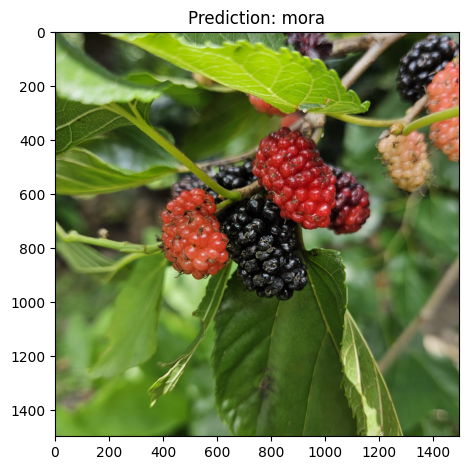

In [42]:
model = PretrainedResNet(num_classes=2)
model.load_state_dict(torch.load('fruit_model.pth'))

def predict_image(image_path, model, device):
    model = model.to(device)
    image = Image.open(image_path)
    image_tensor = test_transforms(image).float()
    image_tensor = image_tensor.unsqueeze(0)
    image_tensor = image_tensor.to(device)
    
    output = model(image_tensor)
    index = output.data.cpu().numpy().argmax()
    
    
    plt.title(f'Prediction: {idx_to_class[index]}')
    plt.tight_layout()
    plt.imshow(image)

predict_image(Path(f"{data_dir}/{os.listdir(data_dir)[3]}"), model, device)



With just a few examples of each class we trained a model that can decently predict the two fruits apart. This project can be extended in many ways like adding more fruits, testing other models, gathering more images, and training on different tasks than image classification. However, it served as a useful project to prepare for Azure DP 100. 